In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


<h2>Load data</h2>

In [2]:
train_df = pd.read_parquet(f's3://music-preference-bucket/train/')
valid_df = pd.read_parquet(f's3://music-preference-bucket/validation/')

In [3]:
train_df.columns

Index(['country', 'user_id', 'dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4',
       'dim_5', 'dim_6', 'dim_7',
       ...
       'dim_119', 'dim_120', 'dim_121', 'dim_122', 'dim_123', 'dim_124',
       'dim_125', 'dim_126', 'dim_127', 'log_scaled_scrobbles'],
      dtype='object', length=131)

<h2>prepare dataset</h2>

In [4]:
le = LabelEncoder()

train_X = train_df.drop(['country', 'user_id'], axis=1)
train_y = le.fit_transform(train_df.iloc[:, 0])
valid_X = valid_df.drop(['country', 'user_id'], axis=1)
valid_y = le.transform(valid_df.iloc[:, 0])
print(train_X.shape)
print(train_y.shape)
print(valid_X.shape)
print(valid_y.shape)

(255437, 129)
(255437,)
(32123, 129)
(32123,)


In [5]:
train_data = lgb.Dataset(train_X, label=train_y)
valid_data = lgb.Dataset(valid_X, label=valid_y)

<h2>Training Lightgbm model</h2>

In [6]:
params = {
    "objective": "multiclass",
    "num_class": 119,
    "learning_rate": 0.05,
    
    #since I have sufficient data, large trees are built for better classification
    "num_leaves": 63,
    "max_depth": -1,

    "min_data_in_leaf": 50,

    # Regularization via randomness
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,

    # Stability
    "lambda_l2": 2.0,

    # Metrics
    "metric": "multi_logloss",
    "verbosity": -1
}
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.12418


<h2>Calculate Metric to examine model performance</h2>

In [14]:


def get_topk_country_accuracy(k, le, df, y, y_pred):
    top_k_count = df[['user_id', 'country']].groupby('country').count().sort_values(by='user_id', ascending=False)[:k]
    top_k_country_label = le.transform(top_k_count.index.to_list())
    top_k_index = np.where(np.isin(y, top_k_country_label))
    return (y[top_k_index] == np.array(y_pred)[top_k_index]).mean()

def get_tailk_country_accuracy(k, le, df, y, y_pred):
    top_k_count = df[['user_id', 'country']].groupby('country').count().sort_values(by='user_id', ascending=False).tail(k)
    top_k_country_label = le.transform(top_k_count.index.to_list())
    top_k_index = np.where(np.isin(y, top_k_country_label))
    return (y[top_k_index] == np.array(y_pred)[top_k_index]).mean()

def topk_acc(k, y, y_prob):
    topk_acc = np.mean([
        y[i] in np.argsort(y_prob[i])[-k:]
        for i in range(len(y))
    ])
    return topk_acc

def output_metrics(train_y_prob, train_y, valid_y_prob, valid_y, le, a=True, b=True, c=True, d=True, e=True, f=True, g=True, h=True, k1=10, k2=5):
    train_y_pred = np.argmax(train_y_prob, axis=1)
    valid_y_pred = np.argmax(valid_y_prob, axis=1)
    
    if a:
        train_acc = (train_y_pred == train_y).mean()
        valid_acc = (valid_y_pred == valid_y).mean()
        print(f"training accuracy: {train_acc}")
        print(f"validation accuracy: {valid_acc}")

    if b:
        print(f"training accuracy for top {k1} countries:{get_topk_country_accuracy(k1, le, train_df, train_y, train_y_pred)}")
        print(f"validation accuracy for top {k1} countries:{get_topk_country_accuracy(k1, le, valid_df, valid_y, valid_y_pred)}")

    if c:
        print(f"training accuracy for tail {k1} countries:{get_tailk_country_accuracy(k1, le, train_df, train_y, train_y_pred)}")
        print(f"validation accuracy for tail {k1} countries:{get_tailk_country_accuracy(k1, le, valid_df, valid_y, valid_y_pred)}")

    if d:
        print(f'top{k2} accuracy of training: {topk_acc(k2, train_y, train_y_prob)}')
        print(f'top{k2} accuracy of validaton: {topk_acc(k2, valid_y, valid_y_prob)}')

    if e:
        print(f'train Macro recall: {recall_score(train_y, train_y_pred, zero_division=0, average="macro")}')
        print(f'validation Macro recall: {recall_score(valid_y, valid_y_pred, zero_division=0, average="macro")}')

    if f:
        print(f'train Macro precision: {precision_score(train_y, train_y_pred, zero_division=0, average="macro")}')
        print(f'validation Macro precision: {precision_score(valid_y, valid_y_pred, zero_division=0, average="macro")}')

    if g:
        print(f'train Macro f1: {f1_score(train_y, train_y_pred, zero_division=0, average="macro")}')
        print(f'validation Macro f1: {f1_score(valid_y, valid_y_pred, zero_division=0, average="macro")}')
    if h:
        print(f'train accuracy: {accuracy_score(train_y, train_y_pred)}')
        print(f'validation accuracy: {accuracy_score(valid_y, valid_y_pred)}')

In [8]:
train_y_prob = model.predict(train_X)
valid_y_prob = model.predict(valid_X)

In [9]:
output_metrics(train_y_prob, train_y, valid_y_prob, valid_y, le, a=True, b=True, c=True, d=True, k1=10, k2=5)

training accuracy: 0.6598848248296058
validation accuracy: 0.5045294648694082
training accuracy for top 10 countries:0.6984821241437128
validation accuracy for top 10 countries:0.6452061945362798
training accuracy for tail 10 countries:0.9002217294900222
validation accuracy for tail 10 countries:0.0
top5 accuracy of training: 0.9347353750631271
top5 accuracy of validaton: 0.7419294586433397
train Macro recall: 0.7685098271292383
validation Macro recall: 0.07325228841703592
train Macro precision: 0.957286232098812
validation Macro precision: 0.15461463815748647
train Macro f1: 0.8311340806063884
validation Macro f1: 0.0853215936831941
train accuracy: 0.6598848248296058
validation accuracy: 0.5045294648694082


LightGBM is not performing as accurately as I expect mostly because the classes are very imbalanced (very long tail) <br>
there is an extreme overfitting to countries with insufficient data <br>
the model is underfitting the countires with more data as train and validation accuracy is similar (bias-limited). <br>
The low recall and precision can be explained by the extreme imbalance as the model tends to completely ignore small countries<br>
<b>So need higher complexity for model </b>

<h2>Experiment: Try applying weights to lightgbm</h2>

Probably will overfit more on country with less users which further exagerates the problem

In [10]:
from collections import Counter

class_counts = Counter(train_y)
num_classes = len(class_counts)
N = len(train_y)
class_weights = {}
weight_cap = 5
for c, cnt in class_counts.items():
    class_weights[c] = min(weight_cap, np.sqrt(N / (num_classes * cnt)))

train_weights = np.array([class_weights[y] for y in train_y])

In [11]:
train_data = lgb.Dataset(train_X, label=train_y, weight=train_weights)
valid_data = lgb.Dataset(valid_X, label=valid_y)

In [12]:
weighted_model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.22684


In [13]:
train_y_prob = weighted_model.predict(train_X)
valid_y_prob = weighted_model.predict(valid_X)
output_metrics(train_y_prob, train_y, valid_y_prob, valid_y, le, a=True, b=True, c=True, d=True, k1=10, k2=5)

training accuracy: 0.6989238050869686
validation accuracy: 0.4928867166827507
training accuracy for top 10 countries:0.6740813872679338
validation accuracy for top 10 countries:0.6080563772402993
training accuracy for tail 10 countries:0.9977827050997783
validation accuracy for tail 10 countries:0.0
top5 accuracy of training: 0.925155713541891
top5 accuracy of validaton: 0.7375712106590293
train Macro recall: 0.8957211964655492
validation Macro recall: 0.09136880231030278
train Macro precision: 0.891207435025733
validation Macro precision: 0.10701432174674551
train Macro f1: 0.8881129292231534
validation Macro f1: 0.09229918179779786
train accuracy: 0.6989238050869686
validation accuracy: 0.4928867166827507


Conclusion: overfits more for classes with small sample size. This led to a slight decrease in validation accuracy.

<h2>Try doing two layers of lightgbm</h2>

1. train a model that classifies users into geographical regions (~10 countries)
2. train a model that classifies users' country per region <br/>

I will take top 3 regions then predict the country by applying weight to them <br/>
Should increase the model complexity and reduce the bias<br/>
For the rare countries, they are basically ungeneralizable due to the small sample size

<h3>Train region classifier</h3>

In [5]:
train_countries = train_df['country'].unique()
valid_countries = valid_df['country'].unique()
country_list = np.union1d(train_countries, valid_countries)

In [6]:
#use chatgpt to create a dictionary to map country to region
country_to_region = {
    #Africa
    'Algeria': 'Africa',
    'Angola': 'Africa',
    'Chad': 'Africa',
    'Egypt': 'Africa',
    'Morocco': 'Africa',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'South Africa': 'Africa',
    'Tunisia': 'Africa',
    'Zimbabwe': 'Africa',
    'Jamaica': 'Africa',

    #Asia
    'China': 'East Asia',
    'Hong Kong': 'East Asia',
    'Japan': 'East Asia',
    "Korea, Democratic People's Republic of": 'East Asia',
    'Korea, Republic of': 'East Asia',
    'Mongolia': 'East Asia',
    'Taiwan': 'East Asia',
    'Malaysia': 'East Asia',
    'Philippines': 'East Asia',
    'Viet Nam': 'East Asia',
    'Singapore': 'East Asia',
    'Thailand': 'East Asia',

    'Afghanistan': 'West Asia',
    'Bangladesh': 'West Asia',
    'India': 'West Asia',
    'Indonesia': 'West Asia',
    'Iran, Islamic Republic of': 'West Asia',
    'Iraq': 'West Asia',
    'Israel': 'West Asia',
    'Jordan': 'West Asia',
    'Kazakhstan': 'West Asia',
    'Lebanon': 'West Asia',
    'Pakistan': 'West Asia',
    'Philippines': 'West Asia',
    'Saudi Arabia': 'West Asia',
    'Singapore': 'East Asia',
    'Sri Lanka': 'West Asia',
    'Syrian Arab Republic': 'West Asia',
    'Turkey': 'West Asia',
    'United Arab Emirates': 'West Asia',
    'Palestinian Territory, Occupied': 'West Asia',
    'Nepal': 'West Asia',

    #Europe
    'Sweden': 'Nordics',
    'Norway': 'Nordics',
    'Denmark': 'Nordics',
    'Finland': 'Nordics',
    'Iceland': 'Nordics',

    'Germany': 'Western Core / DACH',
    'Austria': 'Western Core / DACH',
    'Switzerland': 'Western Core / DACH',
    'Netherlands': 'Western Core / DACH',
    'Belgium': 'Western Core / DACH',
    'France': 'Western Core / DACH',
    'Luxembourg': 'Western Core / DACH',

    'United Kingdom': 'Anglo-Europe',
    'Ireland': 'Anglo-Europe',

    'Spain': 'Southern Europe',
    'Italy': 'Southern Europe',
    'Holy See (Vatican City State)': 'Southern Europe',
    'Portugal': 'Southern Europe',
    'Greece': 'Southern Europe',
    'Malta': 'Southern Europe',
    'Cyprus': 'Southern Europe',

    'Poland': 'Central & Eastern Europe',
    'Czech Republic': 'Central & Eastern Europe',
    'Slovakia': 'Central & Eastern Europe',
    'Hungary': 'Central & Eastern Europe',
    'Romania': 'Central & Eastern Europe',
    'Estonia': 'Central & Eastern Europe',
    'Latvia': 'Central & Eastern Europe',
    'Lithuania': 'Central & Eastern Europe',
    'Ukraine': 'Central & Eastern Europe',
    'Moldova': 'Central & Eastern Europe',
    'Belarus': 'Central & Eastern Europe',

    'Serbia': 'Balkans',
    'Croatia': 'Balkans',
    'Bosnia and Herzegovina': 'Balkans',
    'Bulgaria': 'Balkans',
    'Montenegro': 'Balkans',
    'Macedonia': 'Balkans',
    'Albania': 'Balkans',
    'Slovenia': 'Balkans',
    'Armenia': 'Balkans',
    'Azerbaijan': 'Balkans',
    'Georgia': 'Balkans',
    'Russian Federation': 'Balkans',

    #America
    'Canada': 'Anglo-America',
    'United States': 'Anglo-America',
    'Puerto Rico': 'Anglo-America',
    'Virgin Islands, British': 'Anglo-America',
    'Virgin Islands, U.s.': 'Anglo-America',
    'Cuba': 'Anglo-America',
    'Dominican Republic': 'Anglo-America',

    'Mexico': 'Latin America',
    'Costa Rica': 'Latin America',
    'El Salvador': 'Latin America',
    'Guatemala': 'Latin America',
    'Honduras': 'Latin America',
    'Nicaragua': 'Latin America',
    'Panama': 'Latin America',
    'Argentina': 'Latin America',
    'Bolivia': 'Latin America',
    'Chile': 'Latin America',
    'Colombia': 'Latin America',
    'Ecuador': 'Latin America',
    'Paraguay': 'Latin America',
    'Peru': 'Latin America',
    'Uruguay': 'Latin America',
    'Venezuela': 'Latin America',
    'Brazil': 'Latin America',
    'Trinidad and Tobago': 'Latin America',

    #Oceania
    'Australia': 'Oceania',
    'Fiji': 'Oceania',
    'New Zealand': 'Oceania',
    'Cocos (Keeling) Islands': 'Oceania',
    'Christmas Island': 'Oceania',
    'Heard Island and Mcdonald Islands': 'Oceania',
    'United States Minor Outlying Islands': 'Oceania',
    'South Georgia and the South Sandwich Islands': 'Oceania',

    'Antarctica': 'Antarctica'
}

In [7]:
len(country_list) == len(country_to_region.keys())

True

In [8]:
train_region = train_df['country'].apply(lambda x: country_to_region[x])
valid_region = valid_df['country'].apply(lambda x: country_to_region[x])

region_le = LabelEncoder()
train_region_y = region_le.fit_transform(train_region)
valid_region_y = region_le.transform(valid_region)

In [9]:
len(region_le.classes_)

13

In [10]:
region_params={
    "objective": "multiclass",
    "num_class": len(region_le.classes_),
    "learning_rate": 0.05,
    
    #since I have sufficient data, large trees are built for better classification
    "num_leaves": 63, #since I am trying to up the complexity, I will keep it 63 for now
    "max_depth": -1,

    "min_data_in_leaf": 100,

    # Regularization via randomness
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,

    # Stability
    "lambda_l2": 2.0,

    # Metrics
    "metric": "multi_logloss",
    "verbosity": -1
}

train_data = lgb.Dataset(train_X, label=train_region_y)
valid_data = lgb.Dataset(valid_X, label=valid_region_y)

region_model = lgb.train(
    region_params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.38886


In [11]:
train_y_prob = region_model.predict(train_X)
valid_y_prob = region_model.predict(valid_X)

In [15]:
output_metrics(train_y_prob, train_region_y, valid_y_prob, valid_region_y, region_le, a=True, b=False, c=False, d=True, k2=5)

training accuracy: 0.6216092422006209
validation accuracy: 0.5694984901783768
top5 accuracy of training: 0.9267177425353414
top5 accuracy of validaton: 0.8782492295240171
train Macro recall: 0.4159276865304132
validation Macro recall: 0.30134599187428635
train Macro precision: 0.7182292531854024
validation Macro precision: 0.4985733023485481
train Macro f1: 0.4782417945217335
validation Macro f1: 0.3276602935258405
train accuracy: 0.6216092422006209
validation accuracy: 0.5694984901783768


<h3>evaluate region model (region-wise)</h3>

In [16]:
train_probs = train_y_prob
valid_probs = valid_y_prob

metrics = {'region_name': [],'train_acc': [],'train_prec': [],'train_rec': [],'train_f1': [],'train_top3_rec': [],'train_top3_prec': [],'valid_acc': [],'valid_prec': [],'valid_rec': [],'valid_f1': [],'valid_top3_rec': [],'valid_top3_prec': []}
for i in range(13):
    #masks
    train_y_true_region = (train_region_y == i).astype(int)
    valid_y_true_region = (valid_region_y == i).astype(int)
    train_y_pred_region = (np.argmax(train_probs, axis=1) == i).astype(int)
    valid_y_pred_region = (np.argmax(valid_probs, axis=1) == i).astype(int)
    train_top3_preds = np.argsort(train_probs, axis=1)[:, -3:]
    valid_top3_preds = np.argsort(valid_probs, axis=1)[:, -3:]
    region = region_le.inverse_transform([i])[0]
    
    # Compute metrics
    #training
    train_acc = accuracy_score(train_y_true_region, train_y_pred_region)
    train_prec = precision_score(train_y_true_region, train_y_pred_region, zero_division=0)
    train_rec = recall_score(train_y_true_region, train_y_pred_region, zero_division=0)
    train_f1 = f1_score(train_y_true_region, train_y_pred_region, zero_division=0)
    tp = np.any(train_top3_preds[(train_region_y == i)] == i, axis=1)
    train_topk_rec = tp.sum() / train_y_true_region.sum()
    train_topk_prec = tp.sum() / np.any(train_top3_preds == i, axis=1).sum()
    #validation
    valid_acc = accuracy_score(valid_y_true_region, valid_y_pred_region)
    valid_prec = precision_score(valid_y_true_region, valid_y_pred_region, zero_division=0)
    valid_rec = recall_score(valid_y_true_region, valid_y_pred_region, zero_division=0)
    valid_f1 = f1_score(valid_y_true_region, valid_y_pred_region, zero_division=0)
    tp = np.any(valid_top3_preds[(valid_region_y == i)] == i, axis=1)
    valid_topk_rec = tp.sum() / valid_y_true_region.sum()
    valid_topk_prec = tp.sum() / np.any(valid_top3_preds == i, axis=1).sum()

    metrics['region_name'].append(region)

    metrics['train_acc'].append(train_acc)
    metrics['train_prec'].append(train_prec)
    metrics['train_rec'].append(train_rec)
    metrics['train_f1'].append(train_f1)
    metrics['train_top3_rec'].append(train_topk_rec)
    metrics['train_top3_prec'].append(train_topk_prec)
    
    metrics['valid_acc'].append(valid_acc)
    metrics['valid_prec'].append(valid_prec)
    metrics['valid_rec'].append(valid_rec)
    metrics['valid_f1'].append(valid_f1)
    metrics['valid_top3_rec'].append(valid_topk_rec)
    metrics['valid_top3_prec'].append(valid_topk_prec)


In [17]:
region_model_metrics_df = pd.DataFrame(metrics).set_index('region_name')
region_model_metrics_df

,train_acc,train_prec,train_rec,train_f1,train_top3_rec,train_top3_prec,valid_acc,valid_prec,valid_rec,valid_f1,valid_top3_rec,valid_top3_prec
region_name,,,,,,,,,,,,
Africa,0.996312,0.966867,0.256390,0.405303,0.595048,0.700188,0.994926,0.600000,0.036364,0.068571,0.078788,0.156627
Anglo-America,0.778266,0.537369,0.866491,0.663350,0.977298,0.311644,0.755502,0.513155,0.834369,0.635478,0.968556,0.312235
Anglo-Europe,0.921135,0.575156,0.263854,0.361753,0.828026,0.149496,0.911777,0.461034,0.205184,0.283982,0.773275,0.137550
Antarctica,0.998595,1.000000,0.417208,0.588774,0.858766,0.983271,0.997665,0.000000,0.000000,0.000000,0.000000,0.000000
Balkans,0.950825,0.584504,0.510856,0.545204,0.753969,0.288646,0.939265,0.462185,0.389858,0.422952,0.642857,0.245932
Central & Eastern Europe,0.934082,0.552204,0.479559,0.513324,0.788249,0.249445,0.922174,0.443679,0.397182,0.419145,0.725231,0.223171
East Asia,0.983542,0.699934,0.393213,0.503543,0.604943,0.351291,0.979952,0.506757,0.231481,0.317797,0.362654,0.229492
Latin America,0.879097,0.738833,0.866651,0.797654,0.967097,0.447568,0.865704,0.713281,0.852794,0.776824,0.958542,0.440817
Nordics,0.971406,0.755452,0.328363,0.457758,0.551390,0.401723,0.967873,0.612440,0.227353,0.331606,0.380107,0.267500


<h3>Evaluaion for region model</h3>
Although the accuracy is high for all regions, it hides the fact that regions with little users are overlooked. (True Negatives dominate the formula)<br/>
The recall and top3 recalls of regions exposed this problem. Since the model is very conservative on predicting small regions, the true positives are extremely low.<br/>
<b>Therefore, this model is actually a bad routing layer as it ignores tail regions (the real challenge).</b> 

In [18]:
#use weighted reigon model
from collections import Counter

class_counts = Counter(train_region_y)
K = len(class_counts)
cap = 5
class_weights = {}
for region, count in class_counts.items():
    class_weights[region] = min(cap, np.sqrt(len(train_y) / (K * count)))
weights = [class_weights[y] for y in train_region_y]

train_data = lgb.Dataset(train_X, label=train_region_y, weight=weights)
valid_data = lgb.Dataset(valid_X, label=valid_region_y)

region_params={
    "objective": "multiclass",
    "num_class": len(region_le.classes_),
    "learning_rate": 0.05,
    
    "num_leaves": 63,
    "max_depth": -1,

    "min_data_in_leaf": 100,

    # Regularization via randomness
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,

    # Stability
    "lambda_l2": 2.0,

    # Metrics
    "metric": ['multi_logloss', 'multi_error'],
    "verbosity": -1
}

def topk_recall(preds, eval_data):
    y_true = eval_data.get_label().astype(int)
    top3_preds = np.argsort(preds, axis=1)[:, -3:]
    tp = np.any(top3_preds == y_true[:, None], axis=1)
    return 'top3_recall', tp.mean(), True
    
region_model = lgb.train(
    region_params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, first_metric_only=False),
    ],
    feval=topk_recall
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.44855	valid_0's multi_error: 0.436572	valid_0's top3_recall: 0.776609


<h3>Train country classifier given region</h3>

In [20]:
#create list of regions
regions_count = {}
for country, region in country_to_region.items():
    if not(region in regions_count.keys()):
        regions_count[region] = 1
    else:
        regions_count[region] += 1
len(regions_count.keys()) == 13

True

In [21]:
for region, count in regions_count.items():
    train_region_indicies = np.where(train_region == region)[0]
    users_per_country = len(train_region_indicies)/count
    print(f'{region}: {users_per_country}, {count}')

Africa: 113.81818181818181, 11
East Asia: 492.90909090909093, 11
West Asia: 530.4736842105264, 19
Nordics: 1877.8, 5
Western Core / DACH: 2801.4285714285716, 7
Anglo-Europe: 10818.5, 2
Southern Europe: 1626.2857142857142, 7
Central & Eastern Europe: 1683.3636363636363, 11
Balkans: 1228.1666666666667, 12
Anglo-America: 9200.0, 7
Latin America: 3902.0555555555557, 18
Oceania: 1019.5, 8
Antarctica: 616.0, 1


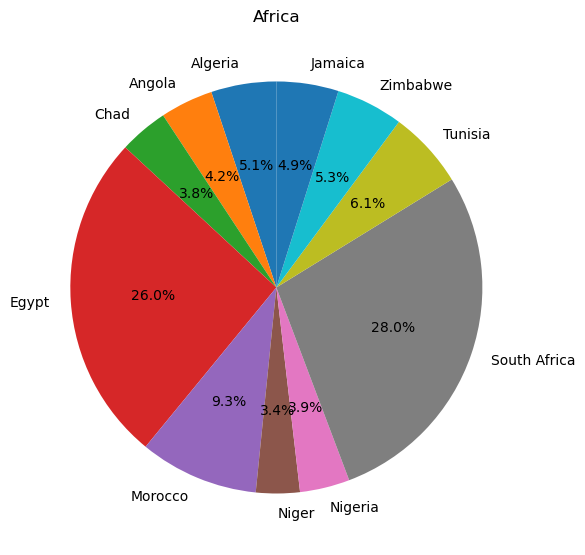

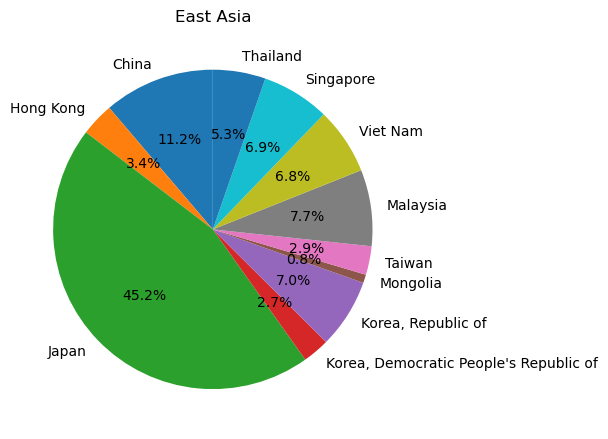

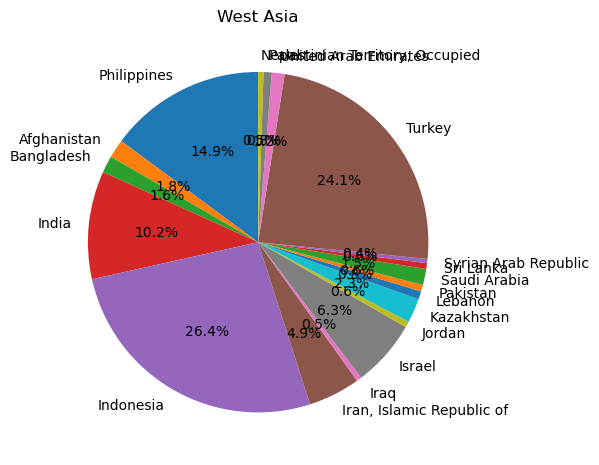

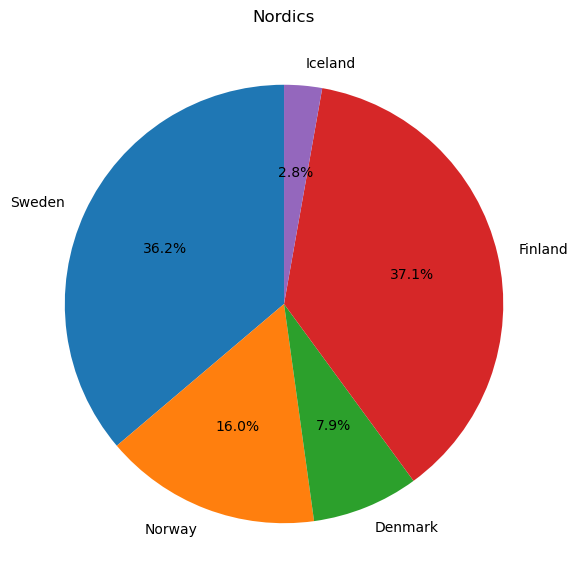

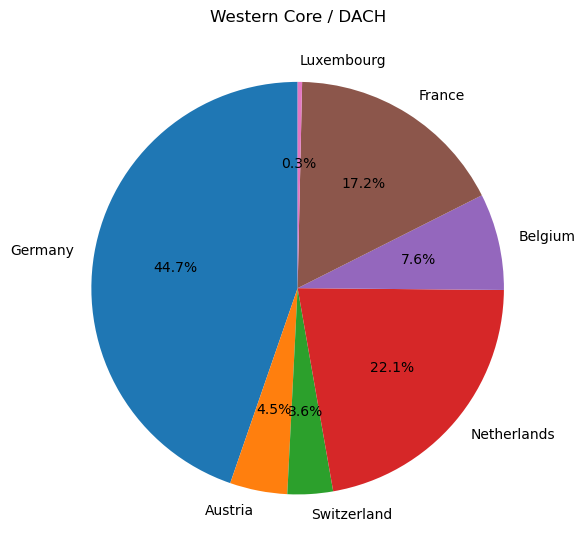

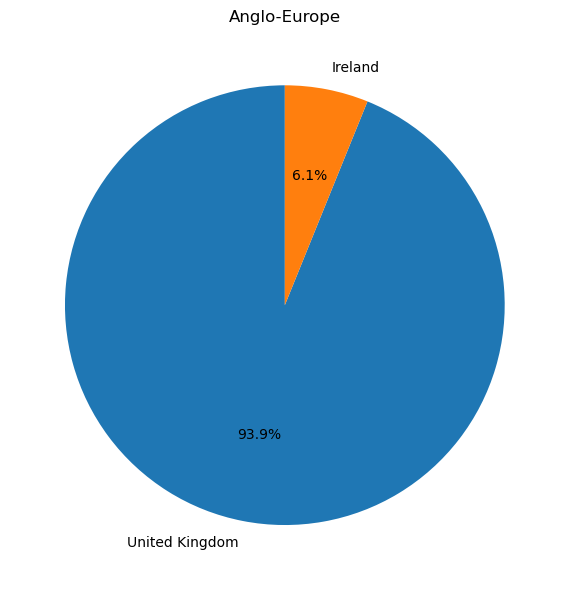

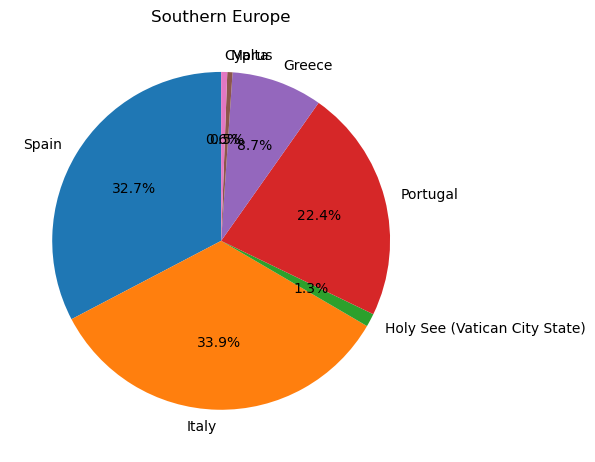

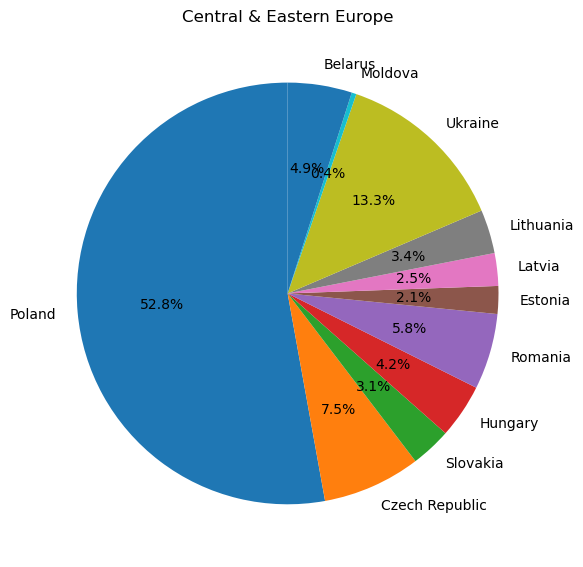

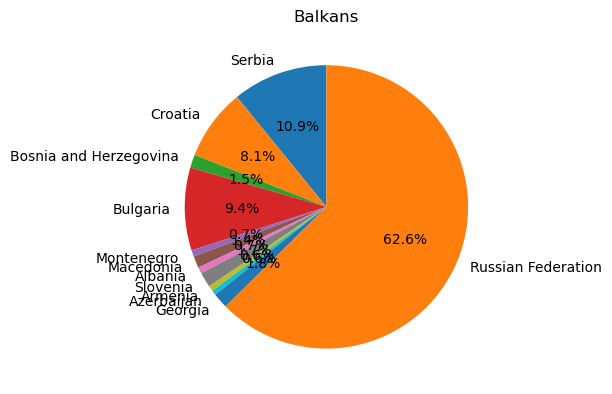

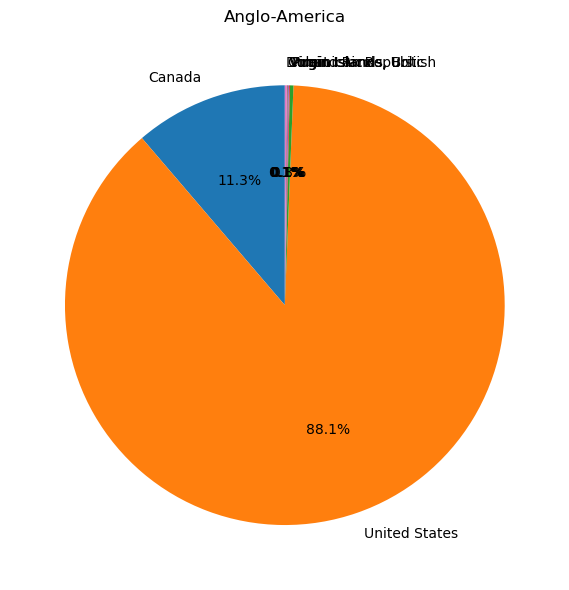

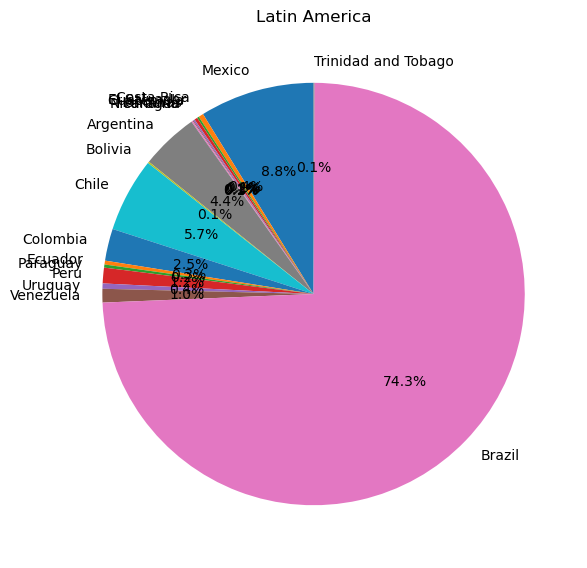

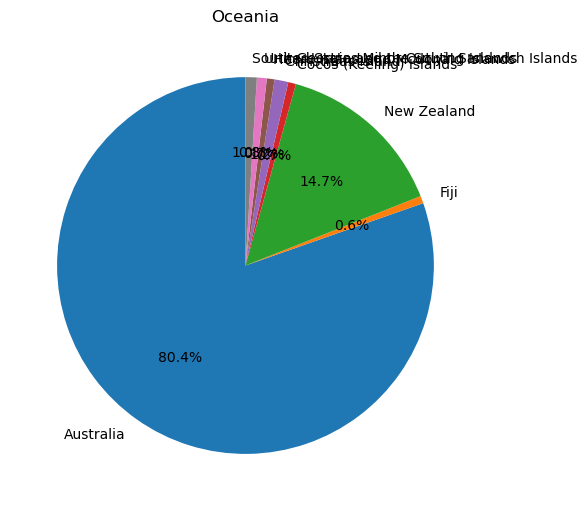

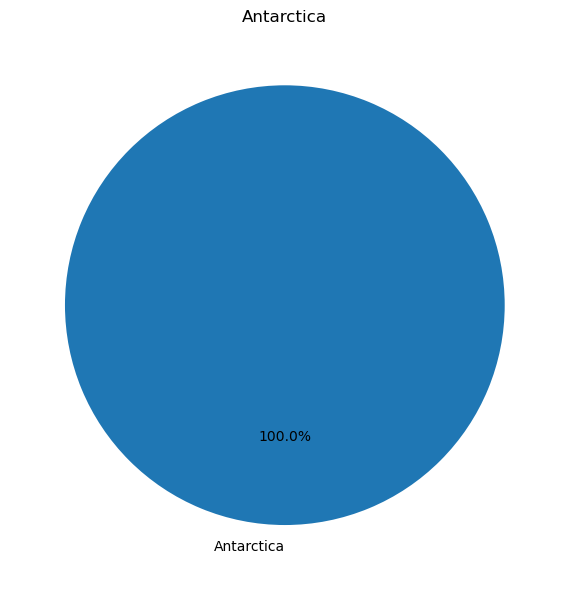

In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# group countries by region
region_to_countries = defaultdict(list)
for country, region in country_to_region.items():
    region_to_countries[region].append(country)

# map country -> label once
country_to_label = {c: le.transform([c])[0] for c in le.classes_}

entropy = {}
effective_classes = {}

# plot pie chart per region
for region, countries in region_to_countries.items():
    counts = []
    labels = []

    for country in countries:
        label = country_to_label[country]
        count = np.sum(train_y == label)
        counts.append(count)
        labels.append(country)

    # skip empty regions (just in case)
    if sum(counts) == 0:
        continue

    p = [count/np.array(counts).sum() for count in counts]
    entropy[region] = -np.sum(p * np.log2(p))
    effective_classes[region] = 1 / np.sum(np.array(p)**2)

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, startangle=90, autopct='%1.1f%%')
    plt.title(region)
    plt.tight_layout()
    plt.show()


In [23]:
entropy

{'Africa': 2.9609074976727987,
 'East Asia': 2.6927642414579385,
 'West Asia': 3.0533014062691213,
 'Nordics': 1.9171009368882992,
 'Western Core / DACH': 2.1204138537798523,
 'Anglo-Europe': 0.33270256053715,
 'Southern Europe': 2.007283461335839,
 'Central & Eastern Europe': 2.3976905207660226,
 'Balkans': 1.9546882077947378,
 'Anglo-America': 0.5747715611874644,
 'Latin America': 1.5257879776917878,
 'Oceania': 1.0005184716054218,
 'Antarctica': -0.0}

In [24]:
effective_classes

{'Africa': 5.811554118685165,
 'East Asia': 4.116009014367208,
 'West Asia': 5.929560299158816,
 'Nordics': 3.3161144262019673,
 'Western Core / DACH': 3.4799388750332585,
 'Anglo-Europe': 1.1301190715583487,
 'Southern Europe': 3.5769674742340283,
 'Central & Eastern Europe': 3.192066582803992,
 'Balkans': 2.3788960018066625,
 'Anglo-America': 1.2673686513539264,
 'Latin America': 1.76808305432484,
 'Oceania': 1.4972080317287662,
 'Antarctica': 1.0}

In [25]:
train_region_indicies = np.where(train_region == 'Africa')[0]
region_train_X = train_X.loc[train_region_indicies]

In [29]:
regions_count

{'Africa': 11,
 'East Asia': 11,
 'West Asia': 19,
 'Nordics': 5,
 'Western Core / DACH': 7,
 'Anglo-Europe': 2,
 'Southern Europe': 7,
 'Central & Eastern Europe': 11,
 'Balkans': 12,
 'Anglo-America': 7,
 'Latin America': 18,
 'Oceania': 8,
 'Antarctica': 1}

In [30]:
models_per_region = {}
metrics = {'region': [], 'entropy': [], 'effective_classes': [], 'train_acc': [], 'train_prec': [], 'train_rec': [], 'train_f1': [], 'train_top3_acc': [], 'train_top3_rec': [], 'train_mean_true_prob':[], 'valid_acc': [], 'valid_prec': [], 'valid_rec': [], 'valid_f1': [], 'valid_top3_acc': [], 'valid_top3_rec': [], 'valid_mean_true_prob': []}

for region, count in regions_count.items():
    if region == 'Antarctica':
        continue
    #extract train and valid data
    print(region)
    temp_le = LabelEncoder()
    train_region_indicies = np.where(train_region == region)[0]
    valid_region_indicies = np.where(valid_region == region)[0]
    region_train_X = train_X.loc[train_region_indicies]
    region_train_y = temp_le.fit_transform(train_df.iloc[train_region_indicies, 0])
    region_valid_X = valid_X.loc[valid_region_indicies]
    region_valid_y = temp_le.transform(valid_df.iloc[valid_region_indicies, 0])

    #add weights
    class_counts = Counter(region_train_y)
    K = len(class_counts)
    cap = 3
    class_weights = {}
    for country, count in class_counts.items():
        class_weights[country] = min(cap, np.sqrt(len(region_train_y) / (K * count)))
    weights = [class_weights[y] for y in region_train_y]
    
    temp_train_data = lgb.Dataset(region_train_X, label=region_train_y, weight=weights)
    temp_valid_data = lgb.Dataset(region_valid_X, label=region_valid_y)
    print(np.unique(region_train_y))

    #get users/country for region to determine parameters
    users_per_country = len(train_region_indicies)/count
    num_leaves = 0
    min_data_in_leaf = 0
    #adjust parameter according to users/country
    if users_per_country < 200:
        num_leaves = 15
        min_data_in_leaf = 300
    elif users_per_country < 600:
        num_leaves = 31
        min_data_in_leaf = 200
    elif users_per_country < 1200:
        num_leaves = 31
        min_data_in_leaf = 150
    elif users_per_country < 2000:
        num_leaves = 47
        min_data_in_leaf = 100
    else:
        num_leaves = 63
        min_data_in_leaf = 50
    
    temp_params={
        "objective": "multiclass",
        "num_class": len(temp_le.classes_),
        "learning_rate": 0.03,
        
        "num_leaves": num_leaves, #less data -> less leaves
        "max_depth": -1,
    
        "min_data_in_leaf": min_data_in_leaf,
    
        # Regularization via randomness
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
    
        # Stability
        "lambda_l2": 2.0,
    
        # Metrics
        "metric": "multi_logloss",
        "verbosity": -1
    }
    
    #train model
    temp_model = lgb.train(
        temp_params,
        temp_train_data,
        valid_sets=[temp_valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
        ]
    )

    #store model in dict
    models_per_region[region] = (temp_model, temp_le)

    train_y_prob = temp_model.predict(region_train_X)
    valid_y_prob = temp_model.predict(region_valid_X)
    print(train_y_prob.shape)
    print(valid_y_prob.shape)

    train_y_pred = np.argmax(train_y_prob, axis=1)
    valid_y_pred = np.argmax(valid_y_prob, axis=1)

    train_top3_preds = np.argsort(train_y_prob, axis=1)[:, -3:]
    valid_top3_preds = np.argsort(valid_y_prob, axis=1)[:, -3:]

    # Compute metrics
    metrics['region'].append(region)
    metrics['entropy'].append(entropy[region])
    metrics['effective_classes'].append(effective_classes[region])

    #training
    metrics['train_acc'].append(accuracy_score(region_train_y, train_y_pred))
    metrics['train_prec'].append(precision_score(region_train_y, train_y_pred, zero_division=0, average='macro'))
    metrics['train_rec'].append(recall_score(region_train_y, train_y_pred, zero_division=0, average='macro'))
    metrics['train_f1'].append(f1_score(region_train_y, train_y_pred, zero_division=0, average='macro'))
    metrics['train_top3_acc'].append(topk_acc(3,region_train_y, train_y_prob))
    metrics['train_mean_true_prob'].append(train_y_prob[np.arange(train_y_prob.shape[0]), region_train_y].mean())
    train_country_top3_recalls = []
    for i in range(len(temp_le.classes_)):
        tps = np.any(train_top3_preds[(region_train_y == i)] == i, axis=1).sum()
        train_topk_rec = tps / (region_train_y == i).sum()
        train_country_top3_recalls.append(train_topk_rec)
    metrics['train_top3_rec'].append(np.array(train_country_top3_recalls).mean())

    #validation
    metrics['valid_acc'].append(accuracy_score(region_valid_y, valid_y_pred))
    metrics['valid_prec'].append(precision_score(region_valid_y, valid_y_pred, zero_division=0, average='macro'))
    metrics['valid_rec'].append(recall_score(region_valid_y, valid_y_pred, zero_division=0, average='macro'))
    metrics['valid_f1'].append(f1_score(region_valid_y, valid_y_pred, zero_division=0, average='macro'))
    metrics['valid_top3_acc'].append(topk_acc(3,region_valid_y, valid_y_prob))
    metrics['valid_mean_true_prob'].append(valid_y_prob[np.arange(valid_y_prob.shape[0]), region_valid_y].mean())
    valid_country_top3_recalls = []
    for i in range(len(temp_le.classes_)):
        tps = np.any(valid_top3_preds[(region_valid_y == i)] == i, axis=1).sum()
        valid_topk_rec = tps / (region_valid_y == i).sum()
        valid_country_top3_recalls.append(valid_topk_rec)
    metrics['valid_top3_rec'].append(np.array(valid_country_top3_recalls).mean())


Africa
[ 0  1  2  3  4  5  6  7  8  9 10]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.87856
(1252, 11)
(165, 11)
East Asia
[ 0  1  2  3  4  5  6  7  8  9 10]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.66772
(5422, 11)
(648, 11)
West Asia
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.41112
(10079, 19)
(1260, 19)
Nordics
[0 1 2 3 4]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.11502
(9389, 5)
(1126, 5)
Western Core / DACH
[0 1 2 3 4 5 6]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1

In [31]:
pd.DataFrame(metrics).set_index('region', drop=True)

,entropy,effective_classes,train_acc,train_prec,train_rec,train_f1,train_top3_acc,train_top3_rec,train_mean_true_prob,valid_acc,valid_prec,valid_rec,valid_f1,valid_top3_acc,valid_top3_rec,valid_mean_true_prob
region,,,,,,,,,,,,,,,,
Africa,2.960907,5.811554,0.497604,0.458773,0.381457,0.388680,0.806709,0.725655,0.216661,0.400000,0.237922,0.216020,0.204335,0.654545,0.464138,0.189278
East Asia,2.692764,4.116009,0.647731,0.611424,0.537348,0.546923,0.893951,0.867334,0.355425,0.489198,0.392209,0.298861,0.312326,0.703704,0.514578,0.285013
West Asia,3.053301,5.929560,0.735490,0.799560,0.743098,0.764094,0.933228,0.953837,0.443612,0.592857,0.268924,0.239740,0.235500,0.813492,0.379332,0.382368
Nordics,1.917101,3.316114,0.663649,0.644306,0.560428,0.591751,0.953243,0.908077,0.426412,0.554174,0.408682,0.363808,0.368810,0.896980,0.734466,0.394537
Western Core / DACH,2.120414,3.479939,0.569760,0.649848,0.418743,0.452029,0.906578,0.796712,0.327158,0.512911,0.252954,0.249536,0.243583,0.853286,0.530005,0.304426
Anglo-Europe,0.332703,1.130119,0.938716,0.969357,0.500377,0.484947,1.000000,1.000000,0.784523,0.936473,0.468237,0.500000,0.483597,1.000000,1.000000,0.778205
Southern Europe,2.007283,3.576967,0.678496,0.734164,0.649225,0.679847,0.955639,0.935677,0.427548,0.555556,0.316502,0.315468,0.314974,0.896011,0.518261,0.385454
Central & Eastern Europe,2.397691,3.192067,0.667225,0.641863,0.466540,0.526648,0.897662,0.808291,0.350703,0.564509,0.236858,0.188966,0.198441,0.782915,0.454942,0.331373
Balkans,1.954688,2.378896,0.742706,0.709623,0.641949,0.656824,0.957728,0.931623,0.465802,0.636314,0.202631,0.196271,0.192140,0.847328,0.383594,0.425711


<h2>get final predictions</h2>

In [32]:
from scipy.special import softmax
def get_final_probs(X):
    #temperature scaling
    region_probs = region_model.predict(X) #(num_users, num_regions)
    temperature = 3
    logits_scaled = region_probs / temperature
    region_probs = softmax(logits_scaled, axis=1)
    user_top3_regions = np.argsort(region_probs, axis=1)[:, -3:]
    final_prob = np.zeros((len(X), len(le.classes_)))
    for region in models_per_region.keys():
        regional_model = models_per_region[region][0]
        regional_le = models_per_region[region][1]
        region_id = region_le.transform([region])[0]
        #get array of users' index
        users_in_region = X[np.any(user_top3_regions == region_id, axis=1)].index
        #P(region | user)
        users_prob_in_region = region_probs[:, region_id] #(#users, )
        #P(country | region, user)
        user_country_probs = regional_model.predict(X.iloc[users_in_region]) #(#user in region, #country in region)
        scaled_user_country_probs = user_country_probs * users_prob_in_region[users_in_region, np.newaxis] #num user in region
        print(f"{region}: {user_country_probs.shape}, {len(regional_le.classes_)}")
        global_country_indicies = le.transform(regional_le.inverse_transform(np.arange(user_country_probs.shape[1])))
        final_prob[np.ix_(users_in_region, global_country_indicies)] += scaled_user_country_probs
    return final_prob

In [33]:
region_probs = region_model.predict(train_X) #(num_users, num_regions)
user_top3_regions = np.argsort(region_probs, axis=1)[:, :3]
user_top3_region_probs = np.take_along_axis(region_probs, user_top3_regions, axis=1)
final_prob = np.zeros((len(train_X), len(le.classes_)))

In [34]:
models_per_region['Anglo-Europe'][0].predict(valid_X).shape

(32123, 2)

In [35]:
train_y_prob = get_final_probs(train_X)
valid_y_probs = get_final_probs(valid_X)

Africa: (4034, 11), 11
East Asia: (20505, 11), 11
West Asia: (37155, 19), 19
Nordics: (27096, 5), 5
Western Core / DACH: (80319, 7), 7
Anglo-Europe: (104584, 2), 2
Southern Europe: (64237, 7), 7
Central & Eastern Europe: (61459, 11), 11
Balkans: (47343, 12), 12
Anglo-America: (157890, 7), 7
Latin America: (102985, 18), 18
Oceania: (57653, 8), 8
Africa: (430, 11), 11
East Asia: (2476, 11), 11
West Asia: (4571, 19), 19
Nordics: (3315, 5), 5
Western Core / DACH: (10215, 7), 7
Anglo-Europe: (13363, 2), 2
Southern Europe: (8037, 7), 7
Central & Eastern Europe: (7699, 11), 11
Balkans: (5905, 12), 12
Anglo-America: (20028, 7), 7
Latin America: (13018, 18), 18
Oceania: (7221, 8), 8


In [36]:
output_metrics(train_y_prob, train_y, valid_y_probs, valid_y, le, a=True, b=True, c=True, d=True, k1=10, k2=5)

training accuracy: 0.4703155768349926
validation accuracy: 0.43828409550789155
training accuracy for top 10 countries:0.5931298467783747
validation accuracy for top 10 countries:0.5629893857664868
training accuracy for tail 10 countries:0.15521064301552107
validation accuracy for tail 10 countries:0.0
top5 accuracy of training: 0.7809048806555041
top5 accuracy of validaton: 0.6948603804127883
train Macro recall: 0.14261879644939626
validation Macro recall: 0.06251870706692557
train Macro precision: 0.6366666470772547
validation Macro precision: 0.11361791201995255
train Macro f1: 0.18466604944912227
validation Macro f1: 0.06389570384411046
train accuracy: 0.4703155768349926
validation accuracy: 0.43828409550789155
